## Описание проекта
Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

### Описание услуг
Оператор предоставляет два основных типа услуг: 
1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL, от англ. digital subscriber line, «цифровая абонентская линия») или оптоволоконный кабель (Fiber optic).

Также доступны такие услуги:
- Интернет-безопасность: антивирус (DeviceProtection) и блокировка небезопасных сайтов (OnlineSecurity);
- Выделенная линия технической поддержки (TechSupport);
- Облачное хранилище файлов для резервного копирования данных (OnlineBackup);
- Стриминговое телевидение (StreamingTV) и каталог фильмов (StreamingMovies).

За услуги клиенты могут платить каждый месяц или заключить договор на 1–2 года. Доступны различные способы расчёта и возможность получения электронного чека.

### Описание данных
Данные состоят из файлов, полученных из разных источников:

**contract_new.csv — информация о договоре:**
- customerID — ID абонента;
- BeginDate — дата начала действия договора;
- EndDate — дата окончания действия договора;
- Type — тип оплаты: раз в год-два или ежемесячно;
- PaperlessBilling — электронный расчётный лист;
- PaymentMethod — тип платежа;
- MonthlyCharges — расходы за месяц;
- TotalCharges — общие расходы абонента;

**personal_new.csv — персональные данные клиента:**
- customerID — ID пользователя;
- gender — пол;
- SeniorCitizen — является ли абонент пенсионером;
- Partner — есть ли у абонента супруг или супруга;
- Dependents — есть ли у абонента дети;

**internet_new.csv — информация об интернет-услугах:**
- customerID — ID пользователя;
- InternetService — тип подключения;
- OnlineSecurity — блокировка опасных сайтов;
- OnlineBackup — облачное хранилище файлов для резервного копирования данных;
- DeviceProtection — антивирус;
- TechSupport — выделенная линия технической поддержки;
- StreamingTV — стриминговое телевидение;
- StreamingMovies — каталог фильмов;

**phone_new.csv — информация об услугах телефонии:**
- customerID — ID пользователя;
- MultipleLines — подключение телефона к нескольким линиям одновременно.

Информация о договорах актуальна на 1 февраля 2020.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import phik

from phik import resources
from phik.binning import bin_data
from phik.report import plot_correlation_matrix

from catboost import CatBoostClassifier

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from imblearn.pipeline import make_pipeline

from sklearn.model_selection import GridSearchCV

from sklearn.metrics import roc_auc_score, confusion_matrix

from sklearn.preprocessing import OrdinalEncoder, OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

RANDOM = 310723

Взглянем на предоставленные таблицы.

In [2]:
try:
    contract_df = pd.read_csv('F:\Downloads/contract_new.csv')
except FileNotFoundError:
        contract_df = pd.read_csv('/datasets/contract_new.csv')
        
display(contract_df.head())
print('Количество дубликатов:', contract_df.duplicated().sum())
print()
contract_df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


In [3]:
try:
    personal_df = pd.read_csv('F:\Downloads/personal_new.csv')
except FileNotFoundError:
        personal_df = pd.read_csv('/datasets/personal_new.csv')
        
display(personal_df.head())
print('Количество дубликатов:', personal_df.duplicated().sum())
print()
personal_df.info()

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [4]:
try:
    internet_df = pd.read_csv('F:\Downloads/internet_new.csv')
except FileNotFoundError:
        internet_df = pd.read_csv('/datasets/internet_new.csv')

display(internet_df.head())
print('Количество дубликатов:', internet_df.duplicated().sum())
print()
internet_df.info()

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


In [5]:
try:
    phone_df = pd.read_csv('F:\Downloads/phone_new.csv')
except FileNotFoundError:
        phone_df = pd.read_csv('/datasets/phone_new.csv')

display(phone_df.head())
print('Количество дубликатов:', phone_df.duplicated().sum())
print()
phone_df.info()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


Количество дубликатов: 0

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


## Подитог
**Пропусков нет, дубликатов тоже**. \
Размер у всех таблиц, кроме `contract_df` и `personal_df` **разный**.\
Во всех таблицах есть **столбец `customerID`**.

Объединим таблицы в один датасет по столбцу `customerID` по типу `outer`, чтобы не потерять данные.

In [6]:
df = contract_df.merge(personal_df, on='customerID', how='outer')\
.merge(internet_df, on='customerID', how='outer')\
.merge(phone_df, on='customerID', how='outer')
display(df.head())
df.info()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   5517 non-null   object 
 13  OnlineSecurity    5517 non-null   object 
 14  OnlineBackup      5517 non-null   object 
 15  DeviceProtection  5517 non-null   object 
 16  TechSupport       5517 non-null   object 


## Вопросы

1. Является ли `EndDate` таргетом?
2. В таблицах есть приписки `_new`. Что это значит?
3. Период прогноза (месяц, год).

## План работы <a id='plan'></a>

1. Произвести предобработку данных;
2. Произвести EDA;
3. Разделить датафрейм на обучающую и тестовую выборки;
4. Произвести кодирование признаков;
5. Обучить модели, используя кросс-валидацию и подбор гиперпараметров;
6. Выбрать лучшую по метрике ROC-AUC;
7. Посмотреть на feature_importance и матрицу ошибок лучшей модели.

## Предобработка данных

### Обработка пропусков

Пропуски присутствуют в последних 8 признаках. Взглянем на них поподробнее.

In [7]:
df_missing = df.iloc[:,-8:].head(5)
display(df_missing.head())

,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,DSL,No,Yes,No,No,No,No,NaN
1,DSL,Yes,No,Yes,No,No,No,No
2,DSL,Yes,Yes,No,No,No,No,No
3,DSL,Yes,No,Yes,Yes,No,No,NaN
4,Fiber optic,No,No,No,No,No,No,No


Изучим уникальные значения.

In [8]:
for col in df_missing.columns:
    print(col, df[col].unique())

InternetService ['DSL' 'Fiber optic' nan]
OnlineSecurity ['No' 'Yes' nan]
OnlineBackup ['Yes' 'No' nan]
DeviceProtection ['No' 'Yes' nan]
TechSupport ['No' 'Yes' nan]
StreamingTV ['No' 'Yes' nan]
StreamingMovies ['No' 'Yes' nan]
MultipleLines [nan 'No' 'Yes']


Исходя из полученных результатов, можно предпринять следующие действия:
1. В признаке `InternetService` создать третью категорию `No` и заполнить ею пропущенные значения.
2. В остальных признаках заменить пропуски на `No`, так как они как раз свидетельствуют об отсутствии той или иной услуги у абонента.

In [9]:
df.fillna('No', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
 8   gender            7043 non-null   object 
 9   SeniorCitizen     7043 non-null   int64  
 10  Partner           7043 non-null   object 
 11  Dependents        7043 non-null   object 
 12  InternetService   7043 non-null   object 
 13  OnlineSecurity    7043 non-null   object 
 14  OnlineBackup      7043 non-null   object 
 15  DeviceProtection  7043 non-null   object 
 16  TechSupport       7043 non-null   object 


In [10]:
#посмотрим на данные еще раз
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,No
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,No
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Для удобства и наглядности проведения дальнейшего анализа сделаем следующие преобразования:
1. Создадим новый признак `ServiceDays`, указывающий на длительность оказания услуг абоненту в днях (`EndDate` - `BeginDate`, если услуги всё еще оказываются, то указываем `EndDate = 2020-02-01` исходя из информации о проекте);
2. Удалим столбец `customerID`, предварительно убедившись, что идентификаторы не повторяются, а так же `EndDate` и `BeginDate` во избежание утечки;
3. Вычленим из `EndDate` целевую переменную, а именно - ушёл абонент или нет;
4. Убедиться, какие признаки являются категориальными и поменять тип данных в них на `category`;
5. Также поменять тип данных `TotalCharges` на `float64` как и в `MonthlyCharges`.

После этого можно приступить непосредственно к анализу:
1. Построить и проанализировать график матрицы корреляций;
2. Парные диаграмы для оценки распределения числовых переменных по группам оттока;
3. Посмотреть на распределение категориальных признаков по группам оттока.

### Создание `ServiceDays`

In [11]:
# создаём копию столбца, чтобы не терять важную информацию
df['EndDate_Copy'] = df['EndDate']

# меняем 'No' на дату действия договора
df.loc[df['EndDate_Copy'] == 'No', 'EndDate_Copy'] = '2020-02-01'

print(df['EndDate_Copy'].unique())

['2020-02-01' '2017-05-01' '2016-03-01' '2018-09-01' '2018-11-01'
 '2018-12-01' '2019-08-01' '2018-07-01' '2017-09-01' '2015-09-01'
 '2016-07-01' '2016-06-01' '2018-03-01' '2019-02-01' '2018-06-01'
 '2019-06-01' '2020-01-01' '2019-11-01' '2016-09-01' '2015-06-01'
 '2016-12-01' '2019-05-01' '2019-04-01' '2017-06-01' '2017-08-01'
 '2018-04-01' '2018-08-01' '2018-02-01' '2019-07-01' '2015-12-01'
 '2014-06-01' '2018-10-01' '2019-01-01' '2017-07-01' '2017-12-01'
 '2018-05-01' '2015-11-01' '2019-10-01' '2019-03-01' '2016-02-01'
 '2016-10-01' '2018-01-01' '2017-11-01' '2015-10-01' '2019-12-01'
 '2015-07-01' '2017-04-01' '2015-02-01' '2017-03-01' '2016-05-01'
 '2016-11-01' '2015-08-01' '2019-09-01' '2017-10-01' '2017-02-01'
 '2016-08-01' '2016-04-01' '2015-05-01' '2014-09-01' '2014-10-01'
 '2017-01-01' '2015-03-01' '2015-01-01' '2016-01-01' '2015-04-01'
 '2014-12-01' '2014-11-01']


In [12]:
# для подсчёта дней меняем тип данных на datetime
df['EndDate_Copy'] = pd.to_datetime(df['EndDate_Copy'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

# создаем и заполняем нужный нам столбец
df['ServiceDays'] = (df['EndDate_Copy'] - df['BeginDate']).dt.days

# удаляем временный столбец
df.drop('EndDate_Copy', axis=1, inplace=True)

display(df.head())

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,...,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ServiceDays
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,31.04,Female,0,...,No,DSL,No,Yes,No,No,No,No,No,31
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,2071.84,Male,0,...,No,DSL,Yes,No,Yes,No,No,No,No,1036
2,3668-QPYBK,2019-10-01,No,Month-to-month,Yes,Mailed check,53.85,226.17,Male,0,...,No,DSL,Yes,Yes,No,No,No,No,No,123
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1960.6,Male,0,...,No,DSL,Yes,No,Yes,Yes,No,No,No,1371
4,9237-HQITU,2019-09-01,No,Month-to-month,Yes,Electronic check,70.70,353.5,Female,0,...,No,Fiber optic,No,No,No,No,No,No,No,153


### Удаление столбцов

In [13]:
#убедимся в отвутствии повторяющихся идентификаторов
df['customerID'].duplicated().sum()

0

In [14]:
# избавляемся от признаков
df.drop(['customerID'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   BeginDate         7043 non-null   datetime64[ns]
 1   EndDate           7043 non-null   object        
 2   Type              7043 non-null   object        
 3   PaperlessBilling  7043 non-null   object        
 4   PaymentMethod     7043 non-null   object        
 5   MonthlyCharges    7043 non-null   float64       
 6   TotalCharges      7043 non-null   object        
 7   gender            7043 non-null   object        
 8   SeniorCitizen     7043 non-null   int64         
 9   Partner           7043 non-null   object        
 10  Dependents        7043 non-null   object        
 11  InternetService   7043 non-null   object        
 12  OnlineSecurity    7043 non-null   object        
 13  OnlineBackup      7043 non-null   object        
 14  DeviceProtection  7043 n

### Создание target'а

In [15]:
# создаём целевую переменную
df['Churn'] = df['EndDate'].apply(lambda x: 0 if x == 'No' else 1).astype('category')

display(df[['Churn', 'EndDate']].head(10))
display(df[['Churn', 'EndDate']].dtypes)

,Churn,EndDate
0,0,No
1,0,No
2,0,No
3,0,No
4,0,No
5,0,No
6,0,No
7,0,No
8,0,No
9,1,2017-05-01


Churn      category
EndDate      object
dtype: object

In [16]:
# удаляем оставшийся признак после получения целевой переменной
df.drop(['EndDate', 'BeginDate'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   object  
 1   PaperlessBilling  7043 non-null   object  
 2   PaymentMethod     7043 non-null   object  
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   object  
 5   gender            7043 non-null   object  
 6   SeniorCitizen     7043 non-null   int64   
 7   Partner           7043 non-null   object  
 8   Dependents        7043 non-null   object  
 9   InternetService   7043 non-null   object  
 10  OnlineSecurity    7043 non-null   object  
 11  OnlineBackup      7043 non-null   object  
 12  DeviceProtection  7043 non-null   object  
 13  TechSupport       7043 non-null   object  
 14  StreamingTV       7043 non-null   object  
 15  StreamingMovies   7043 non-null   object  
 16  MultipleLines     7043 n

### Изменение типов данных

In [17]:
# посмотрим на уникальные значения в признаках
for column in df.columns:
    unique_values = df[column].unique()
    print(f"Уникальные значения в признаках '{column}': {unique_values}")

Уникальные значения в признаках 'Type': ['Month-to-month' 'One year' 'Two year']
Уникальные значения в признаках 'PaperlessBilling': ['Yes' 'No']
Уникальные значения в признаках 'PaymentMethod': ['Electronic check' 'Mailed check' 'Bank transfer (automatic)'
 'Credit card (automatic)']
Уникальные значения в признаках 'MonthlyCharges': [29.85 56.95 53.85 ... 63.1  44.2  78.7 ]
Уникальные значения в признаках 'TotalCharges': ['31.04' '2071.84' '226.17' ... '325.6' '520.8' '7251.82']
Уникальные значения в признаках 'gender': ['Female' 'Male']
Уникальные значения в признаках 'SeniorCitizen': [0 1]
Уникальные значения в признаках 'Partner': ['Yes' 'No']
Уникальные значения в признаках 'Dependents': ['No' 'Yes']
Уникальные значения в признаках 'InternetService': ['DSL' 'Fiber optic' 'No']
Уникальные значения в признаках 'OnlineSecurity': ['No' 'Yes']
Уникальные значения в признаках 'OnlineBackup': ['Yes' 'No']
Уникальные значения в признаках 'DeviceProtection': ['No' 'Yes']
Уникальные значени

In [18]:
# меняем в выбранных столбцах тип данных на категориальный
exclude_columns = ['customerID', 'BeginDate', 'EndDate', 'MonthlyCharges', 'TotalCharges', 'ServiceDays']

for column in df.columns:
    if column not in exclude_columns:
        df[column] = df[column].astype('category')
        
print(df.dtypes)

Type                category
PaperlessBilling    category
PaymentMethod       category
MonthlyCharges       float64
TotalCharges          object
gender              category
SeniorCitizen       category
Partner             category
Dependents          category
InternetService     category
OnlineSecurity      category
OnlineBackup        category
DeviceProtection    category
TechSupport         category
StreamingTV         category
StreamingMovies     category
MultipleLines       category
ServiceDays            int64
Churn               category
dtype: object


In [19]:
# меняем тип данных на 'float' 
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

# проанализируем вновь появившиеся пропуски
missing_rows = df[df.isnull().any(axis=1)]
display(missing_rows)

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines,ServiceDays,Churn
488,Two year,Yes,Bank transfer (automatic),52.55,NaN,Female,0,Yes,Yes,DSL,Yes,No,Yes,Yes,Yes,No,No,0,0
753,Two year,No,Mailed check,20.25,NaN,Male,0,No,Yes,No,No,No,No,No,No,No,No,0,0
936,Two year,No,Mailed check,80.85,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,No,Yes,Yes,No,0,0
1082,Two year,No,Mailed check,25.75,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0,0
1340,Two year,No,Credit card (automatic),56.05,NaN,Female,0,Yes,Yes,DSL,Yes,Yes,Yes,Yes,Yes,No,No,0,0
3331,Two year,No,Mailed check,19.85,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0,0
3826,Two year,No,Mailed check,25.35,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,Yes,0,0
4380,Two year,No,Mailed check,20.00,NaN,Female,0,Yes,Yes,No,No,No,No,No,No,No,No,0,0
5218,One year,Yes,Mailed check,19.70,NaN,Male,0,Yes,Yes,No,No,No,No,No,No,No,No,0,0
6670,Two year,No,Mailed check,73.35,NaN,Female,0,Yes,Yes,DSL,No,Yes,Yes,Yes,Yes,No,Yes,0,0


Из значений признака `ServiceDays` видно, что это новые пользователи, отсюда и пропуски в `TotalCharges`.
Заменим данные пропуски нулевыми значениями.

In [20]:
# заполняем пропуски нулевыми значениями
df['TotalCharges'].fillna(0, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   gender            7043 non-null   category
 6   SeniorCitizen     7043 non-null   category
 7   Partner           7043 non-null   category
 8   Dependents        7043 non-null   category
 9   InternetService   7043 non-null   category
 10  OnlineSecurity    7043 non-null   category
 11  OnlineBackup      7043 non-null   category
 12  DeviceProtection  7043 non-null   category
 13  TechSupport       7043 non-null   category
 14  StreamingTV       7043 non-null   category
 15  StreamingMovies   7043 non-null   category
 16  MultipleLines     7043 n

## EDA

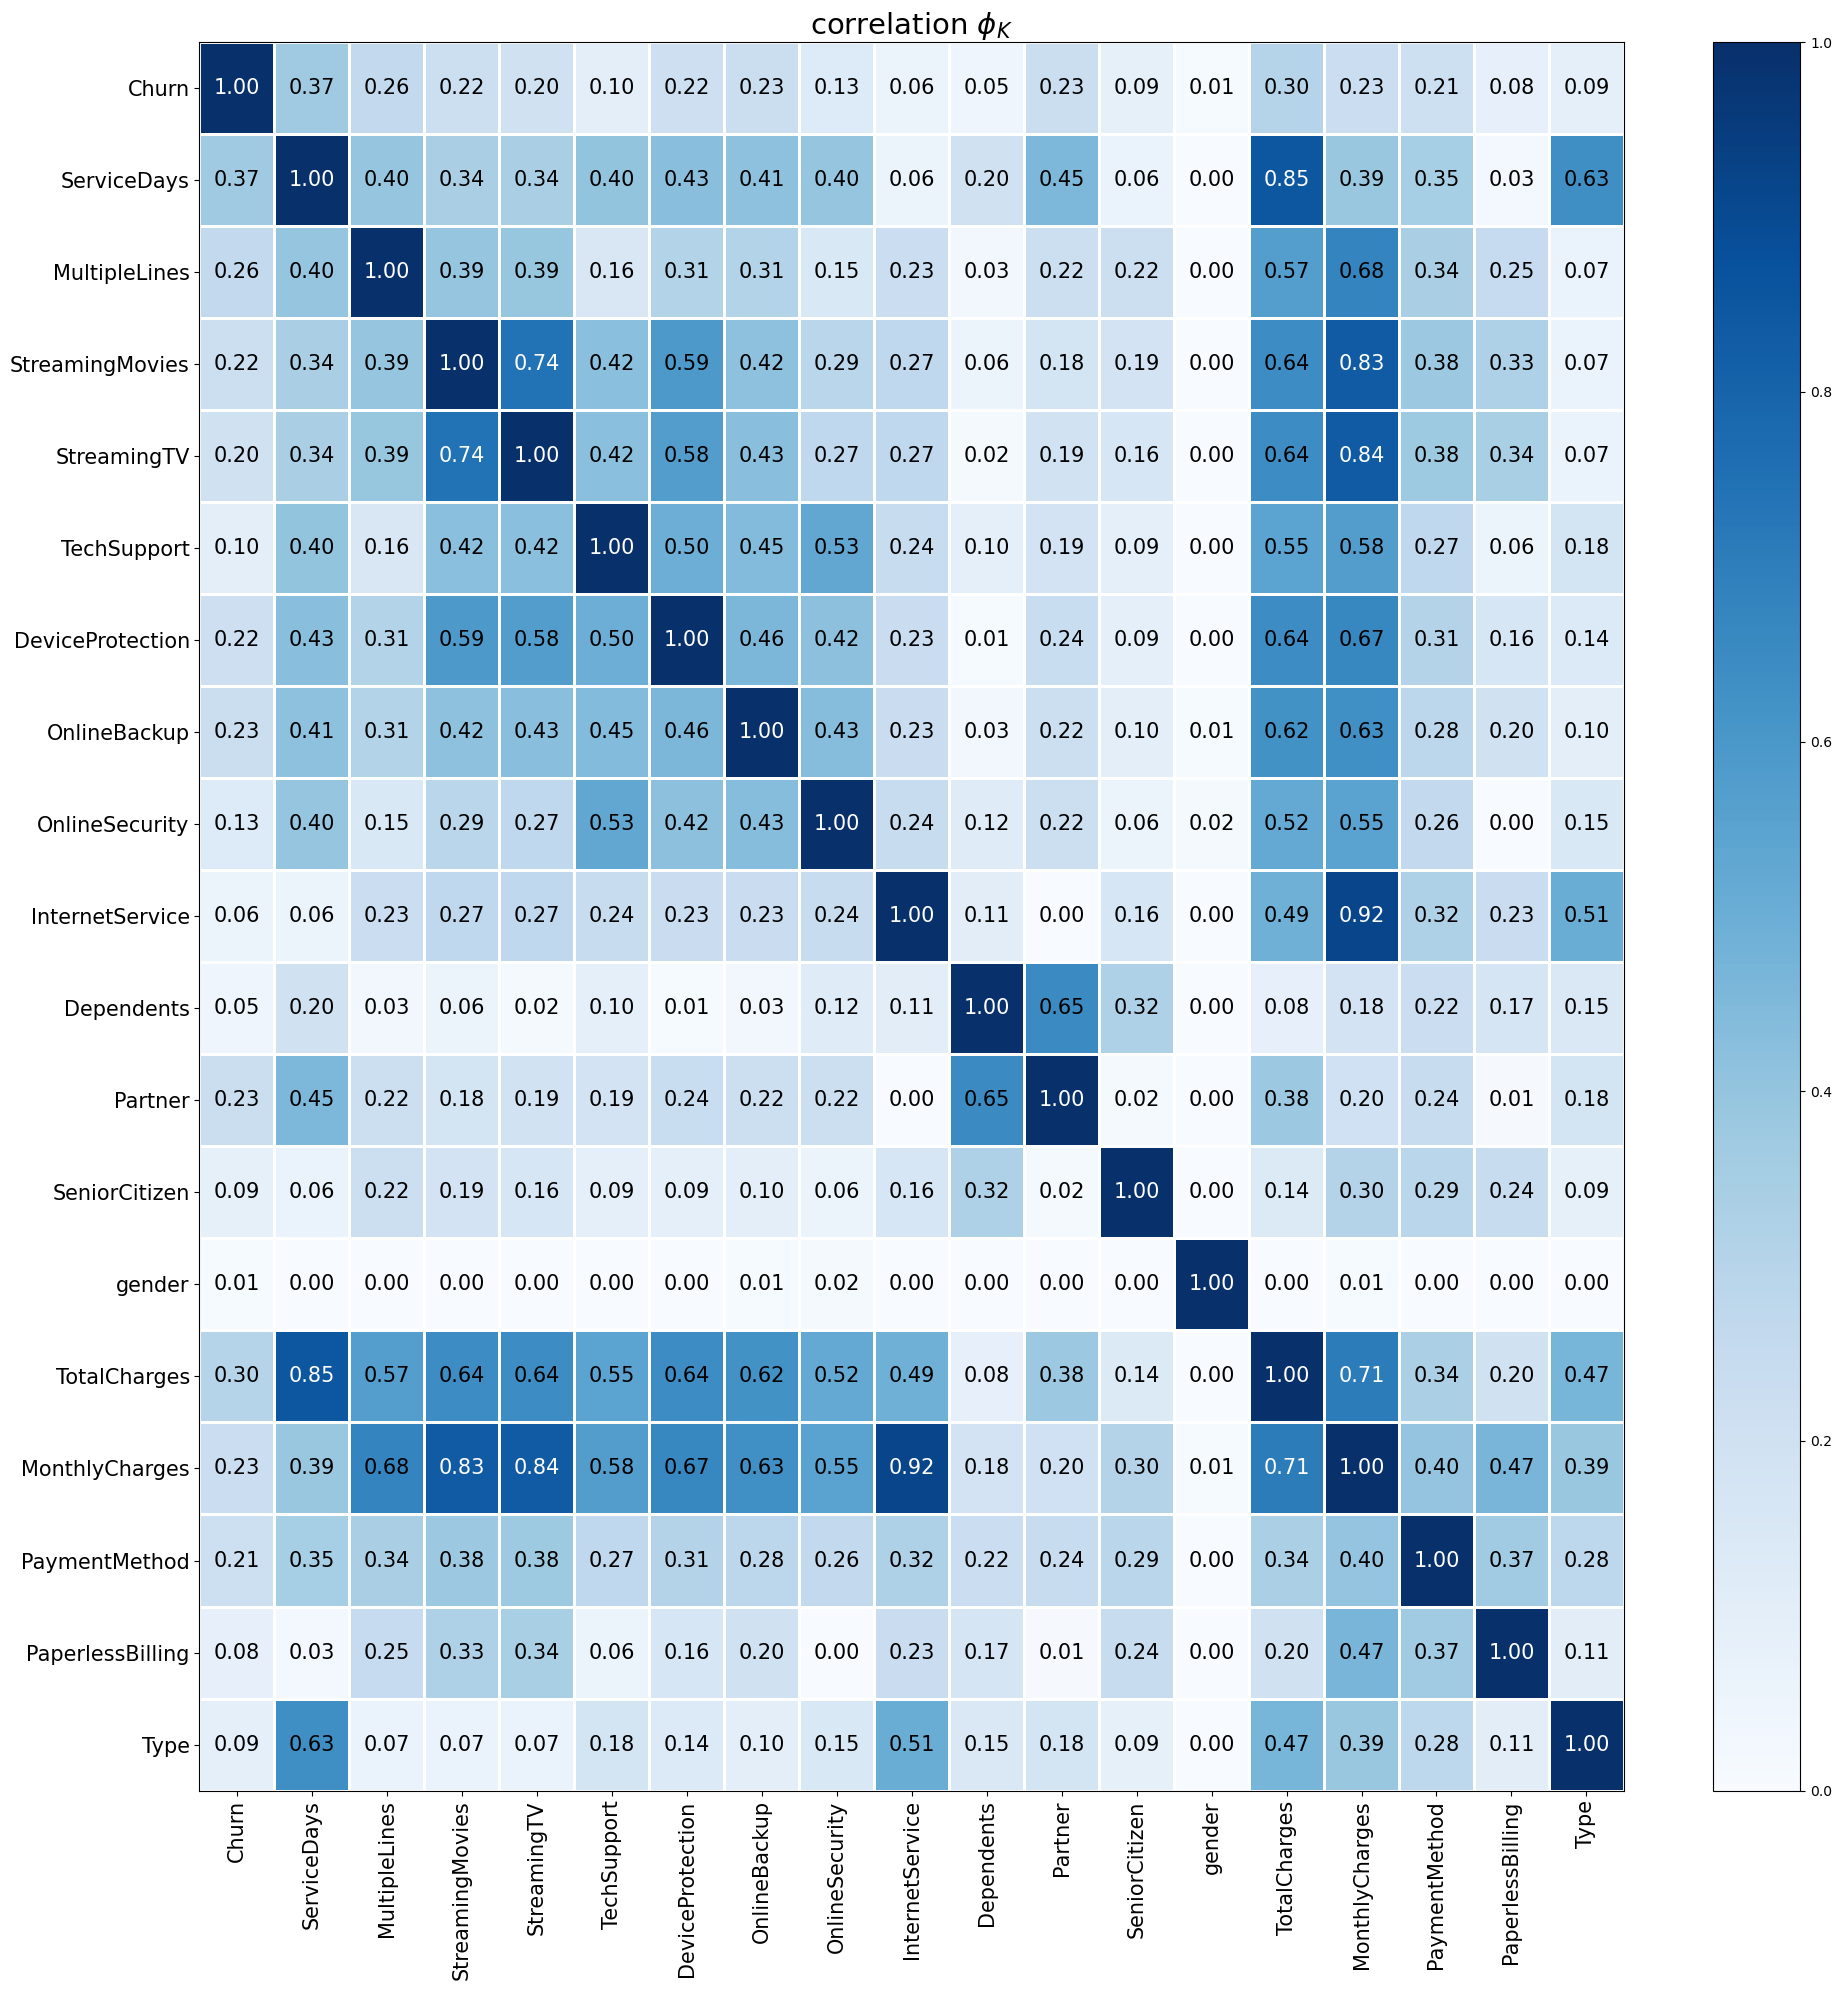

In [21]:
# выделяем числовые столбцы
interval_cols = ['ServiceDays', 'MonthlyCharges', 'TotalCharges']

# строим корреляционную матрицу
phik_overview = df.phik_matrix(interval_cols=interval_cols)

# визуализируем матрицу
plot_correlation_matrix(phik_overview.values,\
                        x_labels=phik_overview.columns,\
                        y_labels=phik_overview.index,\
                       vmin=0,\
                        vmax=1,\
                        color_map='Blues',\
                        title=r'correlation $\phi_K$',\
                        fontsize_factor=1.5,
                        figsize=(20,20))
plt.tight_layout()

На графике матрицы корреляций видны следующий сильные зависимости:

1. `TotalCharges` и `ServiceDays` - логично, чем больше времени клиент провел в компании, тем больше он заплатил за услуги;

2. `MonthlyCharges` и `StreamingMovies`, `StreamingTV`, `InternetService` - логично, наличие услуги увеличивает ежемесячные затраты клиента;

3. `StreamingTV` и `StreamingMovies` - скорее всего, данные услуги если берут, то в комплекте.

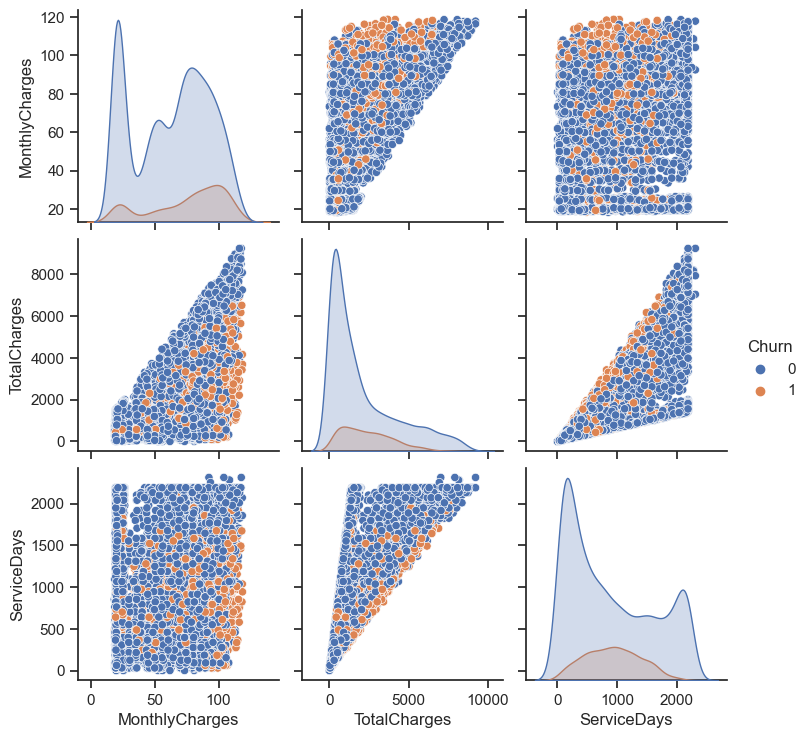

In [22]:
# построим парные диаграммы для отображения распределения с числовыми признаками
sns.set(style='ticks')
sns.pairplot(df, hue='Churn', diag_kind='kde')
plt.show()

Из графиков можно сделать следующие выводы:
1. Можно выделить увеличенное скопление ушедших из компании клиентов с увеличением показателя месячных затрат;
2. Диграмма признака `ServiceDays` показывает расхождения в распределении по группам оттока - ушедшие клиенты показывают нормальное распределение, при этом у оставшихся присутствует два пика в начале и конце графика.

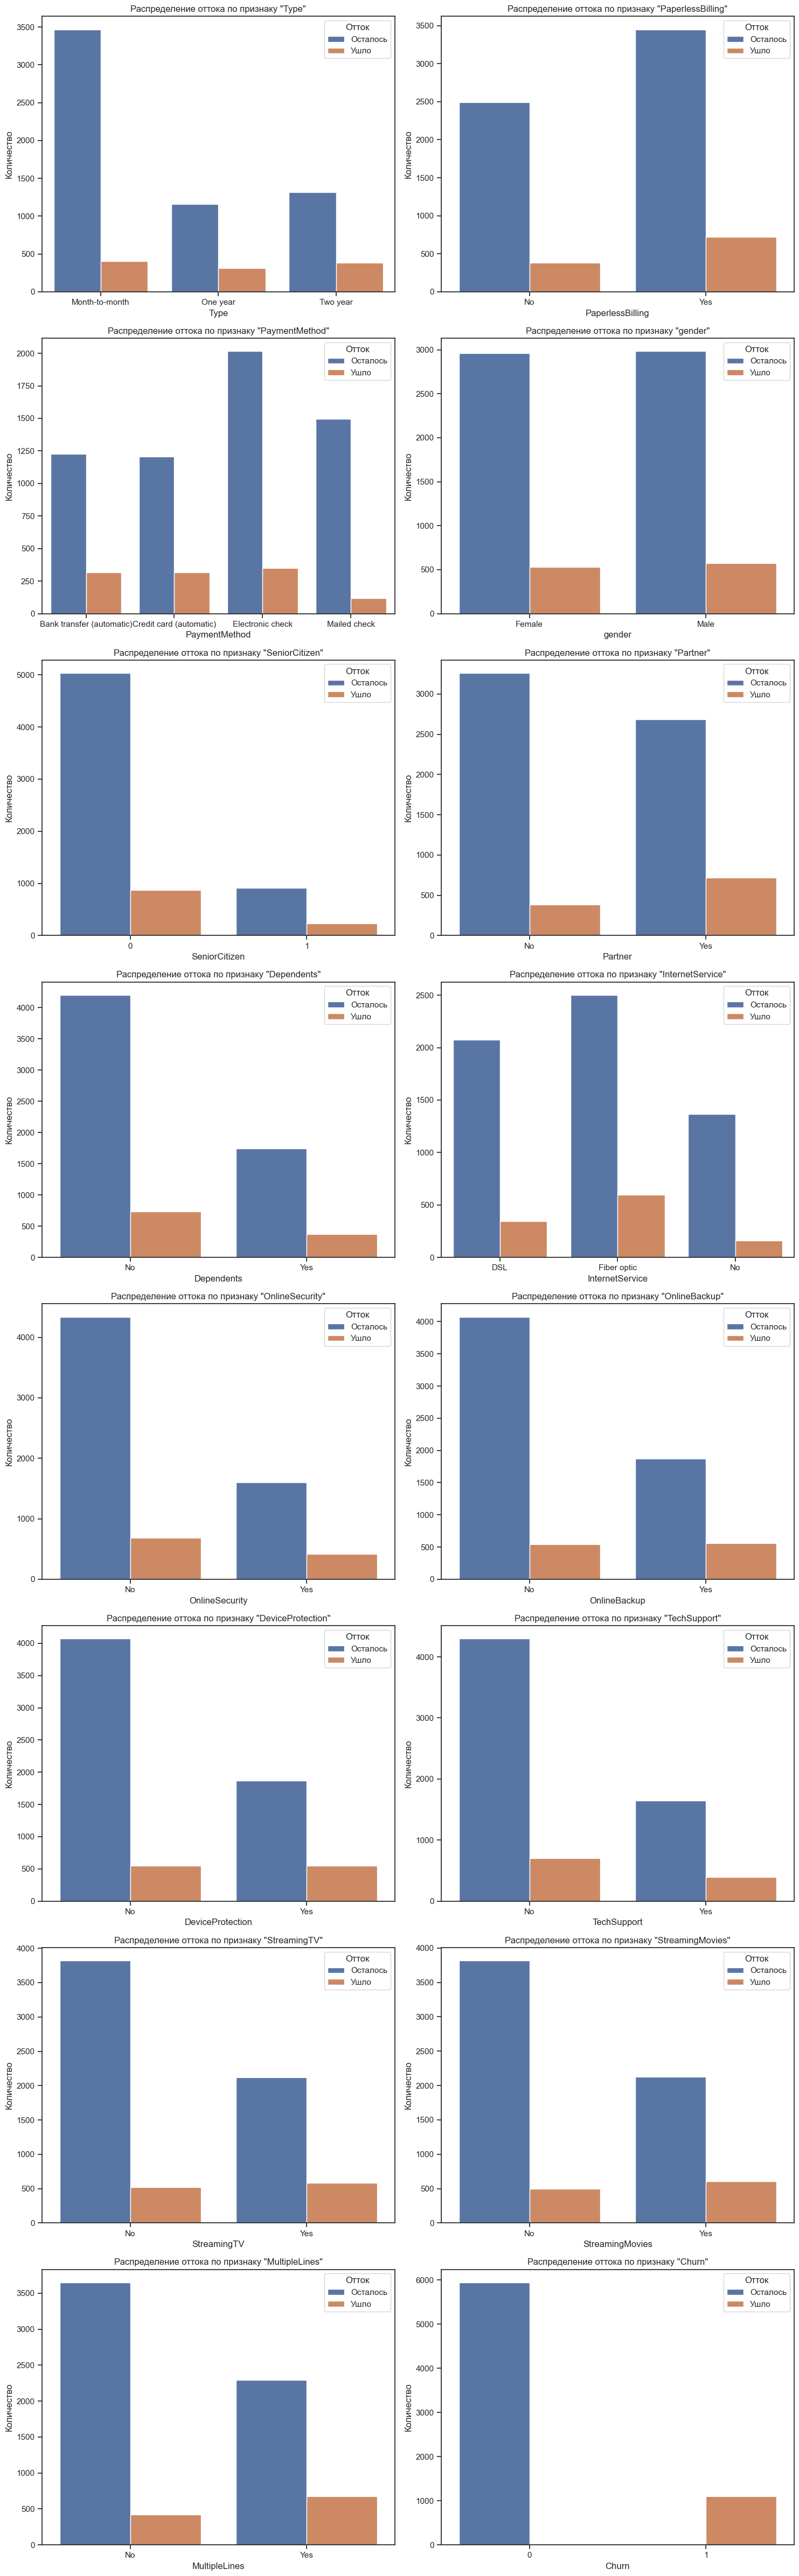

In [23]:
# исключаем числовые признаки
columns_to_exclude = ['MonthlyCharges', 'TotalCharges', 'ServiceDays']
df_plot = df.drop(columns=columns_to_exclude)

# строим графики распределения
num_rows = (len(df_plot.columns) + 1) // 2  

fig, axes = plt.subplots(num_rows, 2, figsize=(15, 6 * num_rows))
axes = axes.flatten() 

for i, col in enumerate(df_plot.columns):
    sns.countplot(data=df_plot, x=col, hue='Churn', ax=axes[i])
    axes[i].set_title(f'Распределение оттока по признаку "{col}"')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel('Количество')
    axes[i].legend(title='Отток', labels=['Осталось', 'Ушло'])

plt.tight_layout()
plt.show()

Из данных графиков, к сожалению, нельзя сделать каких-то явных выводов **ввиду дисбаланса классов** в целевой переменной.

## Разделение датафрейма на выборки

In [24]:
X = df.drop('Churn', axis=1)
y = df['Churn']

X_train, X_test, y_train, y_test \
    = train_test_split(X, y, test_size=0.25, random_state=RANDOM)

variables = [X_train,y_train, X_test,y_test]
for i in variables:
    print(i.shape)

(5282, 18)
(5282,)
(1761, 18)
(1761,)


## Обучение

Для обучения будут использованы следующие модели, и соответственно, применено следующее кодирование признаков:
1. `CatBoostClassifier` - в кодировке не нуждается, надо будет только передать список категориальных признаков;
2. `RandomForestClassifier` - Ordinal Encoding;
3. `LogisticRegression` - One-Hot-Encoding.

In [25]:
# посмотрим на типы столбцов для выделения категориальных признаков
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 18 columns):
 #   Column            Non-Null Count  Dtype   
---  ------            --------------  -----   
 0   Type              7043 non-null   category
 1   PaperlessBilling  7043 non-null   category
 2   PaymentMethod     7043 non-null   category
 3   MonthlyCharges    7043 non-null   float64 
 4   TotalCharges      7043 non-null   float64 
 5   gender            7043 non-null   category
 6   SeniorCitizen     7043 non-null   category
 7   Partner           7043 non-null   category
 8   Dependents        7043 non-null   category
 9   InternetService   7043 non-null   category
 10  OnlineSecurity    7043 non-null   category
 11  OnlineBackup      7043 non-null   category
 12  DeviceProtection  7043 non-null   category
 13  TechSupport       7043 non-null   category
 14  StreamingTV       7043 non-null   category
 15  StreamingMovies   7043 non-null   category
 16  MultipleLines     7043 n

In [26]:
# выделяем категориальные признаки в список из их индексов
cat_features=[0,1,2,5,6,7,8,9,10,11,12,13,14,15,16]
numerical_columns = [3,4,17]

# создаем таблицу, в которую будем выводить лучшие результаты обучения каждой модели
roc_auc_compare = pd.DataFrame(columns=['Model', 'ROC_AUC'])

### CatBoostClassifier

In [27]:
cat_classifier = CatBoostClassifier(random_state=RANDOM,\
                                    cat_features=cat_features,\
                                    iterations=1000)

params = {
    'depth': [4, 6, 8, 10],
    'learning_rate': [0.01, 0.1, 0.2],
}

gsearch_cat = GridSearchCV(
    estimator=cat_classifier,
    param_grid=params,
    verbose=10,
    scoring='roc_auc',
    cv=2
)

gsearch_cat.fit(X_train, y_train)

roc_auc_compare = roc_auc_compare.append({'Model': 'CatBoost', 'ROC_AUC': gsearch_cat.best_score_}, ignore_index=True)

print('ROC-AUC CatBoost:', gsearch_cat.best_score_)
print('CatBoost parameters:', gsearch_cat.best_params_)

Fitting 2 folds for each of 12 candidates, totalling 24 fits
[CV 1/2; 1/12] START depth=4, learning_rate=0.01................................
0:	learn: 0.6852549	total: 190ms	remaining: 3m 9s
1:	learn: 0.6778584	total: 204ms	remaining: 1m 41s
2:	learn: 0.6701413	total: 220ms	remaining: 1m 13s
3:	learn: 0.6631067	total: 234ms	remaining: 58.3s
4:	learn: 0.6566490	total: 252ms	remaining: 50.1s
5:	learn: 0.6503318	total: 269ms	remaining: 44.5s
6:	learn: 0.6444450	total: 287ms	remaining: 40.7s
7:	learn: 0.6384095	total: 305ms	remaining: 37.9s
8:	learn: 0.6318582	total: 323ms	remaining: 35.6s
9:	learn: 0.6256864	total: 340ms	remaining: 33.7s
10:	learn: 0.6201438	total: 358ms	remaining: 32.2s
11:	learn: 0.6145272	total: 373ms	remaining: 30.7s
12:	learn: 0.6087310	total: 391ms	remaining: 29.7s
13:	learn: 0.6033087	total: 408ms	remaining: 28.8s
14:	learn: 0.5973424	total: 428ms	remaining: 28.1s
15:	learn: 0.5908193	total: 444ms	remaining: 27.3s
16:	learn: 0.5850820	total: 462ms	remaining: 26.7s

C:\Users\Ayo\AppData\Local\Temp\ipykernel_9704\2454490876.py:20: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roc_auc_compare = roc_auc_compare.append({'Model': 'CatBoost', 'ROC_AUC': gsearch_cat.best_score_}, ignore_index=True)


### RandomForestClassifier

In [28]:
# создаем список с названиями категориальных признаков для ColumnTransformer'а
cat_column_names = [X.columns[idx] for idx in cat_features]
print(cat_column_names)

['Type', 'PaperlessBilling', 'PaymentMethod', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines']


In [29]:
ordinal_encoder = OrdinalEncoder()



numerical_columns = ['MonthlyCharges', 'TotalCharges', 'ServiceDays']
categorical_columns = cat_column_names


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ordinal_encoder, categorical_columns)
    ],
    remainder='passthrough' 
)


X_encoded = preprocessor.fit_transform(X_train)


encoded_column_names = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(input_features=categorical_columns)
    .tolist()
)


all_column_names = encoded_column_names + numerical_columns


X_train_encoded = pd.DataFrame(X_encoded, columns=all_column_names)





rf_classifier = RandomForestClassifier(random_state=RANDOM)


imba_pipeline_rf = make_pipeline(rf_classifier)


params = {
    'randomforestclassifier__n_estimators': np.arange(50, 100, 10),
    'randomforestclassifier__max_depth': [4, 6, 8, 10],
    'randomforestclassifier__min_samples_split': [2, 5, 10],
    'randomforestclassifier__min_samples_leaf': [1, 2, 4],
}


gsearch_rf = GridSearchCV(
    estimator=imba_pipeline_rf,
    param_grid=params,
    verbose=10,
    scoring='roc_auc',
    cv=2
)


gsearch_rf.fit(X_train_encoded, y_train)
roc_auc_compare = roc_auc_compare.append({'Model': 'RandomForest', 'ROC_AUC': gsearch_rf.best_score_}, ignore_index=True)


print('ROC-AUC RandomForest:', gsearch_rf.best_score_)
print('RandomForest parameters:', gsearch_rf.best_params_)

Fitting 2 folds for each of 180 candidates, totalling 360 fits
[CV 1/2; 1/180] START randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50
[CV 1/2; 1/180] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.774 total time=   0.2s
[CV 2/2; 1/180] START randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50
[CV 2/2; 1/180] END randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, randomforestclassifier__min_samples_split=2, randomforestclassifier__n_estimators=50;, score=0.844 total time=   0.0s
[CV 1/2; 2/180] START randomforestclassifier__max_depth=4, randomforestclassifier__min_samples_leaf=1, randomforestclassifi

C:\Users\Ayo\AppData\Local\Temp\ipykernel_9704\673856613.py:60: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roc_auc_compare = roc_auc_compare.append({'Model': 'RandomForest', 'ROC_AUC': gsearch_rf.best_score_}, ignore_index=True)


### LogisticRegression

In [30]:
ohe_encoder = OneHotEncoder()
scaler = StandardScaler()

numerical_columns = ['MonthlyCharges', 'TotalCharges', 'ServiceDays']
categorical_columns = cat_column_names


preprocessor = ColumnTransformer(
    transformers=[
        ('cat', ohe_encoder, categorical_columns),
        ('num', scaler, numerical_columns)  
    ],
    remainder='passthrough'
)


X_encoded = preprocessor.fit_transform(X_train)


encoded_column_names = (
    preprocessor.named_transformers_['cat']
    .get_feature_names_out(input_features=categorical_columns)
    .tolist()
)


all_column_names = encoded_column_names + numerical_columns


X_train_encoded = pd.DataFrame(X_encoded, columns=all_column_names)


logreg_classifier = LogisticRegression(random_state=RANDOM)


imba_pipeline_logreg = make_pipeline(logreg_classifier)


logreg_params = {
    'logisticregression__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'logisticregression__penalty': ['l1', 'l2'],
    'logisticregression__solver': ['liblinear', 'saga']
}


gsearch_logreg = GridSearchCV(
    estimator=imba_pipeline_logreg,
    param_grid=logreg_params,
    verbose=10,
    scoring='roc_auc',
    cv=2
)


gsearch_logreg.fit(X_train_encoded, y_train)
roc_auc_compare = roc_auc_compare.append({'Model': 'LogReg', 'ROC_AUC': gsearch_logreg.best_score_}, ignore_index=True)

print('ROC-AUC LogisticRegression:', gsearch_logreg.best_score_)
print('LogisticRegression parameters:', gsearch_logreg.best_params_)

Fitting 2 folds for each of 24 candidates, totalling 48 fits
[CV 1/2; 1/24] START logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear
[CV 1/2; 1/24] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.500 total time=   0.0s
[CV 2/2; 1/24] START logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear
[CV 2/2; 1/24] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.500 total time=   0.0s
[CV 1/2; 2/24] START logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=saga
[CV 1/2; 2/24] END logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.500 total time=   0.0s
[CV 2/2; 2/24] START logisticregression__C=0.001, logisticregression__penalty=l1, logisticregression__solver=saga
[CV 2/2; 2/24] END logisticr

C:\Users\Ayo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ayo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2; 16/24] END logisticregression__C=1, logisticregression__penalty=l2, logisticregression__solver=saga;, score=0.777 total time=   0.0s
[CV 1/2; 17/24] START logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=liblinear
[CV 1/2; 17/24] END logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.751 total time=   0.1s
[CV 2/2; 17/24] START logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=liblinear
[CV 2/2; 17/24] END logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=liblinear;, score=0.778 total time=   0.0s
[CV 1/2; 18/24] START logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=saga
[CV 1/2; 18/24] END logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.751 total time=   0.1s
[CV 2/2; 18/24] START logisticregression__C=10, logisticregression__penal

C:\Users\Ayo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ayo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2; 18/24] END logisticregression__C=10, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.778 total time=   0.1s
[CV 1/2; 19/24] START logisticregression__C=10, logisticregression__penalty=l2, logisticregression__solver=liblinear
[CV 1/2; 19/24] END logisticregression__C=10, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.751 total time=   0.0s
[CV 2/2; 19/24] START logisticregression__C=10, logisticregression__penalty=l2, logisticregression__solver=liblinear
[CV 2/2; 19/24] END logisticregression__C=10, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.778 total time=   0.0s
[CV 1/2; 20/24] START logisticregression__C=10, logisticregression__penalty=l2, logisticregression__solver=saga
[CV 1/2; 20/24] END logisticregression__C=10, logisticregression__penalty=l2, logisticregression__solver=saga;, score=0.751 total time=   0.0s
[CV 2/2; 20/24] START logisticregression__C=10, logisticregression__pena

C:\Users\Ayo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
C:\Users\Ayo\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


[CV 2/2; 22/24] END logisticregression__C=100, logisticregression__penalty=l1, logisticregression__solver=saga;, score=0.778 total time=   0.1s
[CV 1/2; 23/24] START logisticregression__C=100, logisticregression__penalty=l2, logisticregression__solver=liblinear
[CV 1/2; 23/24] END logisticregression__C=100, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.751 total time=   0.0s
[CV 2/2; 23/24] START logisticregression__C=100, logisticregression__penalty=l2, logisticregression__solver=liblinear
[CV 2/2; 23/24] END logisticregression__C=100, logisticregression__penalty=l2, logisticregression__solver=liblinear;, score=0.778 total time=   0.0s
[CV 1/2; 24/24] START logisticregression__C=100, logisticregression__penalty=l2, logisticregression__solver=saga
[CV 1/2; 24/24] END logisticregression__C=100, logisticregression__penalty=l2, logisticregression__solver=saga;, score=0.751 total time=   0.0s
[CV 2/2; 24/24] START logisticregression__C=100, logisticregressi

C:\Users\Ayo\AppData\Local\Temp\ipykernel_9704\632704233.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  roc_auc_compare = roc_auc_compare.append({'Model': 'LogReg', 'ROC_AUC': gsearch_logreg.best_score_}, ignore_index=True)


### Выбор лучшей модели

In [31]:
display(roc_auc_compare)

,Model,ROC_AUC
0,CatBoost,0.879404
1,RandomForest,0.822438
2,LogReg,0.764372


По итогам сравнения метрики ROC-AUC победил `CatBoostClassifier`.

Осуществим предикт на тестовой выборке, используя обученную модель с лучшими гиперпараметрами:
- 'catboostclassifier__depth': 4
- 'catboostclassifier__learning_rate': 0.2

In [32]:
best_cat_model = gsearch_cat.best_estimator_

# выбираем вероятность предсказания положительного класса
y_pred = best_cat_model.predict_proba(X_test)[:, 1] 

roc_auc = roc_auc_score(y_test, y_pred)
print('ROC-AUC on Test Set:', roc_auc)

ROC-AUC on Test Set: 0.927330063924267


## Анализ важности признаков и матрицы ошибок

### Важность признаков

In [33]:
feature_importance = best_cat_model.feature_importances_

for feature_name, importance in zip(X.columns, feature_importance):
    print(f"{feature_name}: {importance}")

Type: 6.300470540218898
PaperlessBilling: 0.7086193052037467
PaymentMethod: 3.8697344170777654
MonthlyCharges: 12.35948577826848
TotalCharges: 10.37929278022053
gender: 0.8529416635310422
SeniorCitizen: 0.7506688259006649
Partner: 2.3794235722427968
Dependents: 1.3869328757367227
InternetService: 1.8681779040516
OnlineSecurity: 0.8819953327100296
OnlineBackup: 1.6199860979483676
DeviceProtection: 1.3625986537683104
TechSupport: 0.6833208964350028
StreamingTV: 0.8645382938861822
StreamingMovies: 1.0518962968020575
MultipleLines: 2.060641497426149
ServiceDays: 50.619275268571755


Из результатов `feature_importances_` видно, что, согласно модели, наибольшее влияние на отток имеют:
1. `ServiceDays` - количество дней, сколько человек пользуется услугами компании;
2. Его затраты (`MonthlyCharges` и `TotalCharges`).

### Матрица ошибок

In [34]:
y_pred = best_cat_model.predict(X_test)

# Создание матрицы ошибок
conf_matrix = confusion_matrix(y_test, y_pred)

print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[1459   26]
 [  93  183]]


Иначе матрицу ошибок можно расписать так:

- True Negative (TN) = 1459 Верно классифицированные негативные примеры;
- False Positive (FP) = 26 Ложно классифицированные положительные примеры;
- False Negative (FN) = 93 Ложно классифицированные негативные примеры;
- True Positive (TP) = 183 Верно классифицированные положительные примеры.

Из данных показателей можно рассчитать такие показатели, как **accuracy** и **recall**:

In [35]:
TN = 1459
FP = 26
FN = 93
TP = 183

accuracy = (TN + TP) / (TN + FP + FN + TP)
print(f"Accuracy: {accuracy:.3f}")

recall = TP / (TP + FN)
print(f"Recall: {recall:.3f}")

Accuracy: 0.932
Recall: 0.663


**Точность (accuracy)** равна примерно 93.1%, что означает, что наша модель *правильно классифицировала около **93.1%** всех примеров*.

**Полнота (recall)** равна примерно 66.3%, что означает, что наша модель *обнаружила примерно **66.3%** всех действительных положительных случаев*.

# Итоги

В результате работы были выполнены все пункты [плана](#plan), далее подробнее о работе над ними:
1. Произведена предобработка данных:
    - дубликатов не было, но были пропуски, их заменили на `No`. **Однако** были **"скрытые" пропуски** в формате `string` в столбце `TotalCharges`, которые были выявлены только на этапе подготовки типов данных в признаках. Эти пропуски заменил на **нули**, т.к. взглянув на значения этих пользователей в других признаках стало ясно, что это просто **новые клиенты**;
    - для создания **`ServiceDays`** (количество дней в компании) заменили изначальные значения `EndDate` у неушедших клиентов на последнюю дату договора(1 февраля 2020), и вычли из `EndDate` `BeginDate`, предварительно поменяв формат на `datetime`,  после чего удалили использовавшиеся для этих расчетов признаки во избежание утечки и для удобства;
    - так же **удалили признак `customerID`**, по которому соединяли все первоначальные таблицы. Был вариант поставить его в индекс, но в рамках данного проекта смысла этого особо не имело;
    - с заменой типов данных проблем никаких не было;
2. Произведен EDA:
    - построил матрицу корреляций, парные диаграммы и графики распределения по группам оттока;
    - были выявлены некоторые связи благодаря матрице корреляций;
    - так же выявлен явный дисбаланс классов в пользу оставшихся в компании клиентов;
3. Разделил датафрейм на обучающую и тестовую выборки:
    - разделение было произведено в пропорции 0.75 к 0.25;
    - выборку делили на 2 части, так как в процессе обучения валидация производилась за счет кросс-валидации;
4. Произведено кодирование признаков, используя **pipeline**:
    - `RandomForestClassifier` - OrnidalEncoder;
    - `LogisticRegression` - OneHotEncoder;
5. Обучили модели, используя кросс-валидацию и подбор гиперпараметров:
    - проблем бы не было, если бы не одно **НО** - после первого обучения, по метрике победила `LogisticRegression`, но при проверке на тестовой выборке оказалось, что `OneHotEncoder` закодировал значения в числовых признаках как категории, соответственно, не встретив эти конкретные значения в тесте, выдал ошибку. В итоге воспользовался `ColumnTransformer` и все получилось. К сожалению, после увеличения количества итераций в `CatBoostClassifier`, он выдал бОльший ROC-AUC;
6. Выбрана лучшая модель по метрике ROC-AUC:
    - `CatBoostClassifier`, который получил:
        - **0.87** ROC-AUC на **обучающей выборке**;
        - **0.92** ROC-AUC на **тестовой выборке**;
    - лучшими гиперпараметрами, помимо дефолтных, оказались:
        - **`depth` - 4**;
        - **`learning_rate` 0.2**;
    - признаки, на которых обучалась модель, и их `feature_importance` (важность):
        - Type: 6.300470540218898;
        - PaperlessBilling: 0.7086193052037467;
        - PaymentMethod: 3.8697344170777654;
        - **MonthlyCharges: 12.35948577826848**;
        - **TotalCharges: 10.37929278022053**;
        - gender: 0.8529416635310422;
        - SeniorCitizen: 0.7506688259006649;
        - Partner: 2.3794235722427968;
        - Dependents: 1.3869328757367227;
        - InternetService: 1.8681779040516;
        - OnlineSecurity: 0.8819953327100296;
        - OnlineBackup: 1.6199860979483676;
        - DeviceProtection: 1.3625986537683104;
        - TechSupport: 0.6833208964350028;
        - StreamingTV: 0.8645382938861822;
        - StreamingMovies: 1.0518962968020575;
        - MultipleLines: 2.060641497426149;
        - ***ServiceDays: 50.619275268571755***;
7. Оценена матрица ошибок:
    - матрица ошибок выдала следующие результаты:
        - TN = 1459;
        - FP = 26;
        - FN = 93;
        - TP = 183;
    - благодаря матрице ошибок были рассчитаны точность (accuracy) и полнота (recall) модели:
        - **Точность** (accuracy) равна примерно **93.1%**, что означает, что наша модель правильно классифицировала около 93.1% всех примеров;
        - **Полнота** (recall) равна примерно **66.3%**, что означает, что наша модель обнаружила примерно 66.3% всех действительных положительных случаев.